# CS-401, Final Milestone, Project
The following notebook contains the code for the final milestone of the project. The code is divided into 3 parts:
1. Data Pre-processing
2. Exploratory Analysis
3. Observational Study

# Presentation of the dataset
The dataset used in this project is generated from research papers on how users navigate through wikipedia pages. Five files were used from the dataset:
1. The list of all articles in the dataset that a user can navigate too (and through): articles.tsv
2. The categories associated to all these articles: categories.tsv
3. The list of all outgoing links from each article: links.tsv
4. The list of all games initiated by users, where each game is a sequence of articles visited by the user. These articles are finished or not finished (path_finished.tsv & path_unfinished.tsv).

This dataset was taken from the following papers:
1. Robert West and Jure Leskovec:
    Human Wayfinding in Information Networks.
    21st International World Wide Web Conference (WWW), 2012.
.
2. Robert West, Joelle Pineau, and Doina Precup:
     Wikispeedia: An Online Game for Inferring Semantic Distances between Concepts.
     21st International Joint Conference on Artificial Intelligence (IJCAI), 2009.


# Part 0: Imports

The following non-standard packages were added to our environment:
1. sentence-transformers: This package was used to compute semantic distance between article titles and their categories.

In [1]:
# required non-standard packages to be installed for NLP
#!pip install -U sentence-transformers

The following libraries were used to reach our objectives.

In [2]:
# importing libraries
## standard
import numpy as np
import pandas as pd
import os
import random

## visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

## utilities
import urllib.parse as urlparse
from collections import defaultdict
from tqdm.notebook import tqdm_notebook

## browser window output
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

## networks
import networkx as nx

## NLP and semantic matching
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## statistics
from scipy import stats
import statsmodels.formula.api as smf

---
# Part 1: Data Pre-processing
The objective of this first section is to create an interesting dataset to answer our research question from the raw data.

The pre-processing of the data is divided into 3 parts:
1. Data Loading, Transforming & Cleaning
2. Coarse-Grained Analysis (Overall Articles)
3. Fine-Grained Analysis (Individual Links)

## 1.1 Data Loading, Transforming & Cleaning
In this first section, we load the data from the dataset and transform it into a format that is easier to work with. We also clean the data by removing any unnecessary columns and rows.

The data is loaded from the following files:
1. path_finished.tsv
2. path_unfinished.tsv
3. links.tsv
4. articles.tsv
5. categories.tsv

The resulting data structures that are available are:
1. df_users_paths: All the paths taken by users in the dataset as a list of articles visited by the user. The target article and if the game was finished is also included. A first step of filtering is made to remove invalid paths.
2. df_links: All the links between articles in the dataset. The links are stored as a list of outgoing links from each article. Encoding and decoding of the links is done to make them easier to work with. Columns are added to store statistics about the links.
3. df_articles: All the articles in the dataset with encoding and decoding of the titles. A list of associated categories is included as a column.

In [3]:
# helper functions for encoding and decoding.
def url_parse(url):
    """
    Parse URL encoded to readable characters
    """

    return urlparse.unquote(url).casefold()


def url_encode(url):
    """
    URL encode target links
    """

    return urlparse.quote(url)

We start by retrieving the data on how the players played the game: these paths are in the paths_finished and paths_unfinished files. We decided to merge both dataset while only dropping unfinished paths that are one article in length or less (no clicks)

In [4]:
# load finished paths while dropping unused columns.
df_user_finished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_finished.tsv',
                               sep='\t',
                               names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'],
                               comment='#')

df_user_finished = df_user_finished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'rating'], axis=1)

#create a column 'target' with the last article of each path to merge with unfinished paths
df_user_finished['target'] = df_user_finished['path'].apply(lambda x: x.split(';')[-1])

In [5]:
# load unfinished paths while dropping unused columns
df_user_unfinished = pd.read_csv('./data/wikispeedia_paths-and-graph/paths_unfinished.tsv',
                                 sep='\t',
                                 names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
                                 comment='#')

df_user_unfinished = df_user_unfinished.drop(['hashedIpAddress', 'timestamp', 'durationInSec', 'type'], axis=1)

# drop paths with only one article (no clicks were made)
df_user_unfinished = df_user_unfinished[df_user_unfinished.path.str.contains(';')]

In [6]:
# create a new column to store the path type to differentiate finished and unfinished paths after concatenation
df_user_finished['path_type'] = 'finished'
df_user_unfinished['path_type'] = 'unfinished'

df_user_paths = pd.concat([df_user_finished, df_user_unfinished])

# some users clicked on links in the footer (Terms & Conditions + Disclaimer) that are not articles per-say.
# remove all paths containing these links as it is not in the spirit of the game
not_an_article = ['Wikipedia_Text_of_the_GNU_Free_Documentation_License']

df_user_paths = df_user_paths[~df_user_paths.path.str.contains('|'.join(not_an_article))]

# decode URL encoding for paths, case fold
df_user_paths['path'] = df_user_paths['path'].apply(url_parse)
df_user_paths['target'] = df_user_paths['target'].apply(url_parse)

# transform paths to list of inputs (article names or <)
df_user_paths['path'] = df_user_paths['path'].str.split(';')

df_user_paths.head(10)

,path,target,path_type
0,"[14th_century, 15th_century, 16th_century, pac...",african_slave_trade,finished
1,"[14th_century, europe, africa, atlantic_slave_...",african_slave_trade,finished
2,"[14th_century, niger, nigeria, british_empire,...",african_slave_trade,finished
3,"[14th_century, renaissance, ancient_greece, gr...",greece,finished
4,"[14th_century, italy, roman_catholic_church, h...",john_f._kennedy,finished
5,"[14th_century, europe, north_america, united_s...",john_f._kennedy,finished
6,"[14th_century, china, gunpowder, fire]",fire,finished
7,"[14th_century, time, isaac_newton, light, colo...",rainbow,finished
8,"[14th_century, time, light, rainbow]",rainbow,finished
9,"[14th_century, 15th_century, plato, nature, ul...",rainbow,finished


We create the df_lnks dataframe from extracted information, add the new columns of interest and initialize them:

In [7]:
# extract list of links as DataFrame
df_links = pd.read_csv('./data/wikispeedia_paths-and-graph/links.tsv',
                       sep='\t',
                       names=['linkSource_URL', 'linkTarget_URL'],
                       comment='#')
# definitions:
## source is the link of the page on which a link is shown to the user
## target link is the outgoing link on which the user clicks (aka destination article)

# filenames are single encoded (ie C++.htm is encoded at C%2B%2B.htm)
# outgoing names in the HTML source are DOUBLE encoded (ie C++.htm is <a href="../../wp/c/C%252B%252B.htm">

# add a helper column for linkTarget_2URL storing the DOUBLE URL ENCODED string
df_links['linkTarget_2URL'] = df_links['linkTarget_URL'].map(url_encode)
df_links['linkSource_2URL'] = df_links['linkSource_URL'].map(url_encode)

# decode URL encoding for paths, case fold (from URL encoding to readable)
df_links['linkSource'] = df_links['linkSource_URL'].map(url_parse)
df_links['linkTarget'] = df_links['linkTarget_URL'].map(url_parse)

# merge columns in string for easy lookup (unique key), format (source;target)
df_links['linkPair'] = df_links['linkSource'] + ';' + df_links['linkTarget']

# number of impressions will be counted in column 'impressions' for each pair
df_links['impressions'] = pd.Series(np.zeros((len(df_links)), dtype=int))

# number of hits will be counted in column 'hits' for each pair
df_links['clicks'] = pd.Series(np.zeros((len(df_links)), dtype=int))

# to store the x and y position of the unique link pair
df_links['xpos'] = pd.Series(np.zeros((len(df_links)), dtype=int))
df_links['ypos'] = pd.Series(np.zeros((len(df_links)), dtype=int))

# to store the similarity score between the source and target articles
df_links['title_similarity_score'] = pd.Series(np.zeros((len(df_links)), dtype=float))
df_links['category_similarity_score'] = pd.Series(np.zeros((len(df_links)), dtype=float))

# to store the length of each source article
df_links['length'] = pd.Series(np.zeros((len(df_links)), dtype=int))

df_links.head(10)

,linkSource_URL,linkTarget_URL,linkTarget_2URL,linkSource_2URL,linkSource,linkTarget,linkPair,impressions,clicks,xpos,ypos,title_similarity_score,category_similarity_score,length
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,Bede,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,bede,áedán_mac_gabráin;bede,0,0,0,0,0.0,0.0,0
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,Columba,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,columba,áedán_mac_gabráin;columba,0,0,0,0,0.0,0.0,0
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,D%25C3%25A1l_Riata,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,dál_riata,áedán_mac_gabráin;dál_riata,0,0,0,0,0.0,0.0,0
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,Great_Britain,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,great_britain,áedán_mac_gabráin;great_britain,0,0,0,0,0.0,0.0,0
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Ireland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,ireland,áedán_mac_gabráin;ireland,0,0,0,0,0.0,0.0,0
5,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Isle_of_Man,Isle_of_Man,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,isle_of_man,áedán_mac_gabráin;isle_of_man,0,0,0,0,0.0,0.0,0
6,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Monarchy,Monarchy,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,monarchy,áedán_mac_gabráin;monarchy,0,0,0,0,0.0,0.0,0
7,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Orkney,Orkney,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,orkney,áedán_mac_gabráin;orkney,0,0,0,0,0.0,0.0,0
8,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Picts,Picts,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,picts,áedán_mac_gabráin;picts,0,0,0,0,0.0,0.0,0
9,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Scotland,Scotland,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,scotland,áedán_mac_gabráin;scotland,0,0,0,0,0.0,0.0,0


We store the list of articles in a dataframe and decode/encode as required.

In [8]:
# load list of articles
df_articles = pd.read_csv('./data/wikispeedia_paths-and-graph/articles.tsv',
                          sep='\t',
                          names=['title_URL'],
                          comment='#')

# load list of categories for articles
df_categories = pd.read_csv('./data/wikispeedia_paths-and-graph/categories.tsv',
                            sep='\t',
                            names=['title_URL', 'category'],
                            comment='#')

# store article names in series as DOUBLE URL encoded
df_articles['title_2URL'] = df_articles['title_URL'].map(url_encode)

# decode URL encoding to readable characters for path analysis
df_articles['title'] = df_articles['title_URL'].map(url_parse)

# for every article in df_category, concatenate duplicate rows into a list of categories
df_categories = df_categories.groupby('title_URL')['category'].apply(list).reset_index(name='categories')

# for all articles in df_articles, extract the category from df_categories on column 'title_URL'
df_articles = pd.merge(df_articles, df_categories, on='title_URL', how='left')

# for every article in df_category with NaN, replace with a string 'N/A'
df_articles['categories'] = df_articles['categories'].fillna('No Category')

# merge the categories as a long string and remove the subject. prefix
df_articles['categories'] = df_articles['categories'].apply(lambda x: ' '.join(x))
df_articles['categories'] = df_articles['categories'].apply(lambda x: x.replace('subject.', ''))

df_articles.head(10)

,title_URL,title_2URL,title,categories
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,%25C3%2581ed%25C3%25A1n_mac_Gabr%25C3%25A1in,áedán_mac_gabráin,History.British_History.British_History_1500_a...
1,%C3%85land,%25C3%2585land,åland,Countries Geography.European_Geography.Europea...
2,%C3%89douard_Manet,%25C3%2589douard_Manet,édouard_manet,People.Artists
3,%C3%89ire,%25C3%2589ire,éire,Countries Geography.European_Geography.Europea...
4,%C3%93engus_I_of_the_Picts,%25C3%2593engus_I_of_the_Picts,óengus_i_of_the_picts,History.British_History.British_History_1500_a...
5,%E2%82%AC2_commemorative_coins,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,Business_Studies.Currency
6,10th_century,10th_century,10th_century,History.General_history
7,11th_century,11th_century,11th_century,History.General_history
8,12th_century,12th_century,12th_century,History.General_history
9,13th_century,13th_century,13th_century,History.General_history


## 1.2: Fine Grained: Analysis on Specific Links (source;destination)
From the raw data, we want to expand the _df_links_ dataframe by adding extra information about individual link pairs.
         _Reminder: a link pair is a link shown on a source article leading to a destination article and is represented as (source article;target article)_

For each individual and unique link pair, the following metrics will be calculated:
- the number of clicks users made by users in all games played
- the number of impressions
- the CTR of this specific link
- the position of these links on a webpage

In [9]:
# optimization step, preprocessing indices to use numpy arrays for faster accessing
# for all articles names, create a list of rows in the df_links that have this article as source
source_map = defaultdict(list)
for link_id, source in enumerate(df_links['linkSource']):
    source_map[source].append(link_id)

# create a reverse dictionary to index nparray from an article's name
## in other words: list[idx]=string to dict[string]=idx
my_map = dict(df_links['linkPair'])
pair_map = dict((v, k) for k, v in my_map.items())

### 1.2.1 Computing Clicks, Impressions & CTR
The clicks, impressions and CTR metrics will be calculated by analysing the individual games played by players.
For each individual link pair (source;target), we count the number of clicks and impressions to finally compute the click-through rate (CTR).
This is done by analysing all finished and unfinished paths of users playing the game by using a stack data structure.

For this analysis, a stack data structure is used. No impressions are added when the user uses the "back" button; only productive clicks generate impressions.

In [10]:
# some pairs were missing from links.tsv
# when detected, add them to list
def create_link_pair(src, trgt, idx):
    # create row
    new_row = df_links.iloc[:0, :].copy()

    # add row id to source_map[source_node] list
    source_map[src].append(idx)

    # add value of new pair in pair_map
    srch_val = src + ';' + trgt
    pair_map[srch_val] = idx

    # add values to new row
    new_row.at[0, 'linkSource_URL'] = url_encode(src)  # linkSource_URL
    new_row.at[0, 'linkTarget_URL'] = url_encode(trgt)  # linkTarget_URL
    new_row.at[0, 'linkSource_2URL'] = url_encode(url_encode(src))  # linkSource_2URL
    new_row.at[0, 'linkTarget_2URL'] = url_encode(url_encode(trgt))  # linkTarget_2URL
    new_row.at[0, 'linkSource'] = src  # linkSource
    new_row.at[0, 'linkTarget'] = trgt  # linkTarget
    new_row.at[0, 'linkPair'] = srch_val  # linkPair

    return new_row

In [11]:
# column constants for numpy array indexing
IMPRESSIONS_COLUMN_ID = df_links.columns.get_loc('impressions')
CLICKS_COLUMN_ID = df_links.columns.get_loc('clicks')
XPOS_COLUMN_ID = df_links.columns.get_loc('xpos')
YPOS_COLUMN_ID = df_links.columns.get_loc('ypos')

# numpy array to make operations faster
np_links = df_links.to_numpy()

# create iterable series of paths
series_paths = df_user_paths['path'].squeeze()

for path in series_paths:
    # initialise stack with first link
    foo = list()
    foo.append(path[0])
    # iterate over every step of user's path
    for element in path[1:]:
        if element != '<':
            # if next element in path is not a return character, store information and analyze
            ## source node is the current top of stack
            source_node = foo[-1]

            ## add next link in list to top of stack
            foo.append(element)

            ## new top of stack is target
            target_node = foo[-1]

            # create key for pair identification
            search_value = source_node + ';' + target_node

            try:
                pair = pair_map[search_value]
            except Exception as e:
                # catch when pair was not listed in dataset, create it
                print('Created Pair:', e)
                # append row to numpy array
                np_links = np.append(np_links, create_link_pair(source_node, target_node, len(np_links)).to_numpy(),
                                     axis=0)
                break

            ## count one impression for all pairs with source_node as source (source_node;*)
            source = source_map[source_node]
            np_links[source, IMPRESSIONS_COLUMN_ID] += 1

            ## add one click-through for the pair (source_node;target_node)
            np_links[pair, CLICKS_COLUMN_ID] += 1

        else:
            # if return character is read, pop top of stack and don't store any info
            foo.pop()

Created Pair: 'finland;åland'
Created Pair: 'republic_of_ireland;éire'
Created Pair: 'claude_monet;édouard_manet'
Created Pair: 'ireland;éire'
Created Pair: 'impressionism;édouard_manet'
Created Pair: 'francisco_goya;édouard_manet'


### Invalid pairs: Interpretation
Some issues were discovered with the dataset: some link pairs are missing from the list of links (*links.tsv*).
**The users clicked on a link that was not listed in the links.tsv file, but existed on the page.**

This was confirmed by going to the source page (ie *finland*) and confirming that there was a link to the destination (ie *åland*), but this link pair was not listed in the links.tsv source file.

The values obtained in np_links are put back in the df_links dataframe, since dataframes are easier to handle than numpy arrays

In [12]:
columns = df_links.columns
to_dict_values = {}

for i in range(len(columns)):
    col = columns[i]
    to_dict_values[col] = [np_links[k][i] for k in range(len(np_links))]

df_links = pd.DataFrame(to_dict_values)

From the number of clicks and the number of impressions, we are able to compute the click-through rate (CTR) for each link pair (source;target)

In [13]:
df_links['CTR'] = df_links.clicks / df_links.impressions

#drop the rows with NaN values in CTR column as they are pages that were never seen by any users
df_links = df_links.dropna(subset=['CTR'])

## 1.2.2 NLP model (BERT) to encode the links and the articles' title
We wanted to compute two semantic similarity metric using cosine distance:
1. The first semantic similarity computed is between the titles of the link pair (source;destination)
2. The second semantic similarity metric is computed between the category of the link pair
    When there is more than one category for an article, they are concatenated. The logic is that this will increase the information contained in the category and will lead to a higher and more representative semantic similarity score using the BERT model.

The similarity metric we computed is based on the cosine distance.

First, we compute similarities between the titles of all link pairs (source;destination). Since this operation takes some time to complete, we save the results in a file to avoid having to recompute the similarity scores every time we run the notebook.
The output file is the first checkpoint of the notebook (_1_output_title_similarity.csv_)

In [14]:
tqdm_notebook.pandas()  # progress bar for pandas

# declare the transformer that takes word as input and outputs a vectorial output that will be used to compute cosine similarity
model = SentenceTransformer('efederici/sentence-bert-base')


def get_embeddings(string):
    return model.encode(string)


def compute_title_similarity(current_row):
    source_title = current_row['linkSource']
    target_title = current_row['linkTarget']
    # embedding for strings
    source_title_embedding = get_embeddings([source_title])
    target_title_embedding = get_embeddings([target_title])
    # compute cosine similarity between the two titles
    return cosine_similarity(source_title_embedding, target_title_embedding)


# check if output file exists and if user wants to overwrite it
answer = 'y'  # by default, create output file
output_title_similarity_score = 'output/1_output_title_similarity.csv'
if os.path.isfile(output_title_similarity_score):
    answer = input(
        'Title Similarity was already computed. \n Do you want to overwrite it? (y/n) \n (Warning: this operation takes a long time)')

if answer == 'n':
    df_links = pd.read_csv(output_title_similarity_score)  # read checkpoint file
else:
    # compute similarity score for each link pair
    df_links['title_similarity_score'] = df_links.progress_apply(compute_title_similarity, axis=1)
    # save results to file
    df_links.to_csv(output_title_similarity_score)
    # df_links at this point contains the similarity score for each link pair

Second, we compute similarities between the categories of all link pairs (source;destination).
Once again, we load the results from a file if it exists, otherwise we compute the similarity scores and save them to a file.
The output file is the second checkpoint of the notebook (_2_output_category_similarity.csv_)

In [15]:
# extract category from df_articles for row with title = article_title
def get_category(article_title):
    try:
        return df_articles[df_articles['title'] == article_title]['categories'].values[0]
    except:
        return ''


def compute_category_similarity(current_row):
    source_category = get_category(current_row['linkSource'])
    target_category = get_category(current_row['linkTarget'])
    # embedding for strings
    source_title_embedding = get_embeddings([source_category])
    target_title_embedding = get_embeddings([target_category])
    # compute cosine similarity between the two titles
    return cosine_similarity(source_title_embedding, target_title_embedding)


# check if output file exists and if user wants to overwrite it
answer = 'y'  # by default, create output file
output_title_similarity_score = 'output/2_output_category_similarity.csv'
if os.path.isfile(output_title_similarity_score):
    answer = input(
        'Category Similarity was already computed.\n Do you want to recompute it? (y/n) \n (Warning: this operation takes a long time)')

if answer == 'n':
    df_links = pd.read_csv(output_title_similarity_score)  # read checkpoint file
else:
    # compute similarity score for each link pair
    df_links['category_similarity_score'] = df_links.progress_apply(compute_category_similarity, axis=1)
    # save results to file
    df_links.to_csv(output_title_similarity_score)
    # df_links at this point contains the both similarity scores for categories and titles for each link pair

## 1.2.3 Computing the physical location of the links in the HTML pages
In this part, we compute the physical location of every link pair (source;destination) in a given HTML page by rendering a virtual page using Selenium to get the actual coordinates of the links.

We create an HTML driver that renders pages in memory. We consider a full screen display to be 1680*900, rendered in Google Chrome. This resolution has been chosen as a compromise between 1080p and 720p. It was also a very popular resolution in early 2010s, when this dataset was generated.

In [16]:
X_DIM = 1680
Y_DIM = 900
op = Options()
op.add_argument('headless')
op.add_argument('window-size=' + str(X_DIM) + ',' + str(Y_DIM))
driver = webdriver.Chrome(options=op)

Now that the driver is configured, let's compute the locations of all links in the articles.

The output file is the third checkpoint of the notebook (_3_output_link_position.csv_)

In [17]:
# for tracking progress
article_counter = 0
number_of_articles = len(df_articles['title_2URL'])

# check if output file exists and if user wants to overwrite it
answer = 'y'  # by default, create output file
output_file_name = 'output/3_output_link_position.csv'
if os.path.isfile(output_file_name):
    answer = input(
        'Link Positions were already computed \n Do you want to recompute it? (y/n)  \n (Warning: this operation takes a long time)')

if answer == 'n':
    df_links = pd.read_csv(output_file_name)

else:
    for index, row in df_articles.iterrows():
        source = row['title_2URL']

        # progress tracking
        if article_counter % 10 == 0:
            print('Article', article_counter, '/', number_of_articles)
        article_counter += 1

        # compute relative path to html
        source_path = '/data/wpcd/wp/' + source[0].lower() + '/' + source + '.htm'

        # absolute path to html file
        user_cwd = os.getcwd().replace('\\', '/')
        source_url = 'file://' + user_cwd + source_path
        # load page in memory
        driver.get(source_url)

        # list of target links we want to find positions #OPTIMIZE
        list_target_articles = df_links.loc[df_links['linkSource_2URL'] == source]['linkTarget_2URL']

        # length of each source article
        len_article = driver.execute_script("return document.body.scrollHeight")

        for target in list_target_articles:
            # the pairs are in readable characters, target is double encoded format
            target_readable = url_parse(url_parse(target))
            source_readable = url_parse(url_parse(source))
            search_pair = source_readable + ';' + target_readable

            try:
                current_pair = pair_map[search_pair]
            except Exception as e:
                # catch when pair was not listed in dataset
                print('Invalid pair:', e)  # for debug
                break

            # find the href with /target.htm within all elements of page
            ## example with target = World War I, we are looking for /World_War_I.htm
            href = driver.find_elements(By.XPATH, ".//a[contains(@href,'/" + target + ".htm')]")
            try:
                # first link is considered (href[0])
                ## we assume that the user reads a page from top to bottom, left to right
                ## he clicks on the first occurence of a link he thinks is good
                df_links.at[current_pair, 'xpos'] = href[0].location['x']
                df_links.at[current_pair, 'ypos'] = href[0].location['y']
                df_links.at[current_pair, 'length'] = len_article
                df_links.at[current_pair, 'is_on_top'] = 1 if href[0].location['y'] < Y_DIM else 0
            except Exception as e:
                print('Not found:', target)
        df_links.to_csv(output_file_name, encoding='utf-8-sig')
    driver.close()
df_links.head(10)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,linkSource_URL,linkTarget_URL,linkTarget_2URL,linkSource_2URL,linkSource,linkTarget,linkPair,impressions,clicks,xpos,ypos,title_similarity_score,length,CTR,is_on_top,category_similarity_score
0,68,68,68,%E2%82%AC2_commemorative_coins,Athens,Athens,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,athens,€2_commemorative_coins;athens,1,0,557,941,0.067500,6472,0.0,0.0,0.574470
1,69,69,69,%E2%82%AC2_commemorative_coins,Atlantic_Ocean,Atlantic_Ocean,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,atlantic_ocean,€2_commemorative_coins;atlantic_ocean,1,0,1131,5592,0.116387,6472,0.0,0.0,0.610068
2,70,70,70,%E2%82%AC2_commemorative_coins,Austria,Austria,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,austria,€2_commemorative_coins;austria,1,0,438,493,-0.088484,6472,0.0,1.0,0.568692
3,71,71,71,%E2%82%AC2_commemorative_coins,Belgium,Belgium,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,belgium,€2_commemorative_coins;belgium,1,0,484,493,0.049557,6472,0.0,1.0,0.568692
4,72,72,72,%E2%82%AC2_commemorative_coins,Berlin,Berlin,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,berlin,€2_commemorative_coins;berlin,1,0,621,6273,-0.010085,6472,0.0,0.0,0.574470
5,73,73,73,%E2%82%AC2_commemorative_coins,Brussels,Brussels,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,brussels,€2_commemorative_coins;brussels,1,0,601,5051,0.120722,6472,0.0,0.0,0.574470
6,74,74,74,%E2%82%AC2_commemorative_coins,Cathedral_of_Magdeburg,Cathedral_of_Magdeburg,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,cathedral_of_magdeburg,€2_commemorative_coins;cathedral_of_magdeburg,1,0,816,6298,0.176546,6472,0.0,0.0,0.678865
7,75,75,75,%E2%82%AC2_commemorative_coins,Cereal,Cereal,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,cereal,€2_commemorative_coins;cereal,1,0,424,1742,0.084645,6472,0.0,0.0,0.533574
8,76,76,76,%E2%82%AC2_commemorative_coins,Christopher_Columbus,Christopher_Columbus,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,christopher_columbus,€2_commemorative_coins;christopher_columbus,1,0,622,5504,0.180437,6472,0.0,0.0,0.589325
9,77,77,77,%E2%82%AC2_commemorative_coins,Cologne,Cologne,%25E2%2582%25AC2_commemorative_coins,€2_commemorative_coins,cologne,€2_commemorative_coins;cologne,1,0,526,4067,-0.010550,6472,0.0,0.0,0.574470


## 1.3: Coarse-Grained: Aggregated View over Whole Dataset
Here, the goal is to extend the _articles_ table by adding columns representing the total number of clicks, the number of impressions and the CTR. Except for the CTR, we can simply sum the obtained numbers in the finer granularity.

In [18]:
# sum the number of clicks, impressions and ctr
df_articles_coarse = df_links[["linkTarget", "impressions", "clicks"]].groupby(by=["linkTarget"]).sum()
df_articles_coarse["CTR"] = df_articles_coarse["clicks"] / df_articles_coarse["impressions"]

---
# Part 2: Exploratory Data Analysis
## 2.1: Wikipedia Dataset Network
To have a better understanding of the dataset, we wish to create a graph of the network.

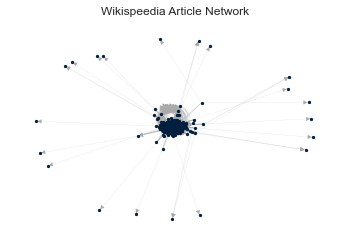

In [19]:
# create a graph of the network
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget', create_using=nx.DiGraph())

# draw graph network
nx.draw_networkx(G, with_labels=False, node_size=5, node_color="#001f3f", width=0.1, edge_color="#AAAAAA")
ax = plt.gca()
ax.set_title('Wikispeedia Article Network')
ax.set_axis_off()
plt.show()

The graph above shows the network of articles. The nodes are the articles and the edges are the links between them. The graph is directed, meaning that the links are not symmetric. The graph is sparse, meaning that there are very few links between most of the articles. The graph is connected, as there are no isolated articles.

## 2.2: Wikispeedia Dataset Network In-Degrees
We investigate the number of links pointing toward each articles

In [20]:
# return the number of edges pointing to a node
in_degree = G.in_degree()

# transform the output into a dataframe to simplify use
pd_graph = pd.DataFrame(in_degree, columns=['articles', 'In degree'])
pd_graph.head(10)

,articles,In degree
0,€2_commemorative_coins,0
1,athens,83
2,atlantic_ocean,237
3,austria,224
4,belgium,223
5,berlin,129
6,brussels,64
7,cathedral_of_magdeburg,1
8,cereal,64
9,christopher_columbus,67


Let's visualize the distribution of the in degree values over the articles.

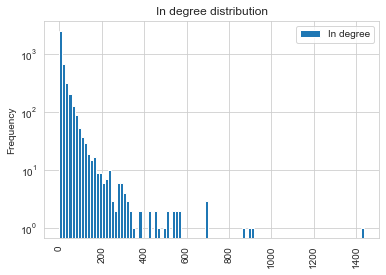

In [21]:
pd_graph.plot.hist(bins=100, rot=90, title="In degree distribution", logy=True);

Let's rank the top 10 articles having the largest in degree value.

In [22]:
pd_graph.sort_values(by=['In degree'], ascending=False).head(10)

,articles,In degree
44,united_states,1435
42,united_kingdom,915
15,france,902
134,europe,866
17,germany,700
98,england,698
187,world_war_ii,698
58,india,573
941,english_language,561
241,japan,546


### 2.3: Data Distribution
Let's explore the dataset we have obtained.

In [23]:
print('There exist', len(df_links), 'links in total.')
print('There are', df_links.linkSource.nunique(), 'unique articles')
print('The pages with the most links are:')
df_links['linkSource'].value_counts()

There exist 113974 links in total.
There are 4172 unique articles
The pages with the most links are:


united_states                     294
driving_on_the_left_or_right      255
list_of_countries                 244
list_of_circulating_currencies    236
list_of_sovereign_states          216
                                 ... 
human_dignity                       1
workchoices                         1
sunol_water_temple                  1
scheme_programming_language         1
terik                               1
Name: linkSource, Length: 4172, dtype: int64

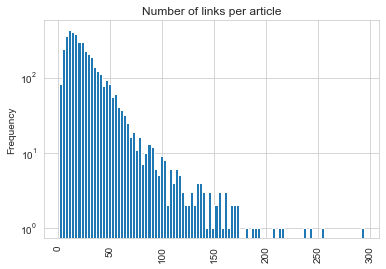

In [24]:
# plot the distribution of the number of links per article
df_links['linkSource'].value_counts().plot.hist(bins=100, rot=90, title="Number of links per article", logy=True);

We can see that the number of links per article does not follow a normal distribution. There are articles that have more than 200 links while others have very little.

<AxesSubplot:title={'center':'Number of clicks'}, ylabel='Frequency'>

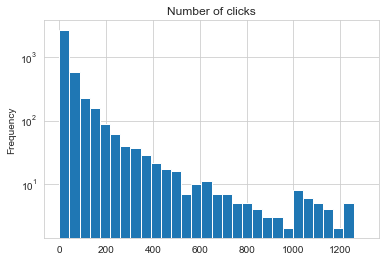

In [25]:
# plot the distribution of the number of clicks per link
df_articles_coarse["clicks"].plot.hist(bins=30, range=[0, 1300], title="Number of clicks", logy=True)

Same for the number of clicks. We can see that the number of clicks per article does not follow a uniform distribution. There are articles that have more than 1000 clicks while others have very little.

Let's rank the top 10 most clicks articles:

In [26]:
df_articles_coarse.sort_values(by=['clicks'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
united_kingdom,123566,5303,0.042916
england,65232,4413,0.067651
earth,61419,4172,0.067927
africa,68411,3490,0.051015
world_war_ii,102791,2893,0.028144
north_america,70097,2546,0.036321
animal,42468,2426,0.057125


Now focusing on impressions:

<AxesSubplot:title={'center':'Number of impressions'}, ylabel='Frequency'>

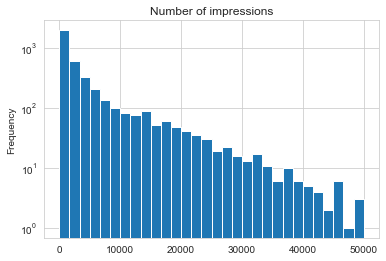

In [27]:
df_articles_coarse["impressions"].plot.hist(bins=30, title="Number of impressions", range=[0, 50000], logy=True)

Let's rank the top 10 articles with highest impressions

In [28]:
df_articles_coarse.sort_values(by=['impressions'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
united_states,154518,12376,0.080094
europe,133170,5565,0.041789
france,132404,2225,0.016805
united_kingdom,123566,5303,0.042916
germany,105443,2167,0.020551
world_war_ii,102791,2893,0.028144
latin,101089,959,0.009487
india,97125,1750,0.018018
spain,93086,773,0.008304


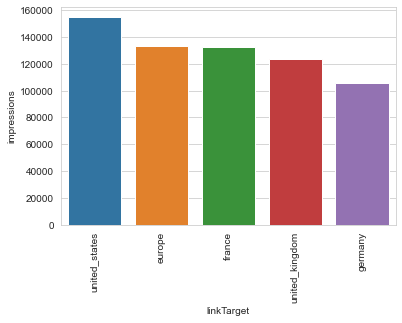

In [29]:
df_top_5_impressions = df_articles_coarse.sort_values(by=['impressions'], ascending=False).head(5).reset_index()
ax = sns.barplot(x="linkTarget", y="impressions", data=df_top_5_impressions)
plt.xticks(rotation=90)
plt.show()

The final analysis is made on CTR:

<AxesSubplot:title={'center':'Distribution of CTR'}, ylabel='Frequency'>

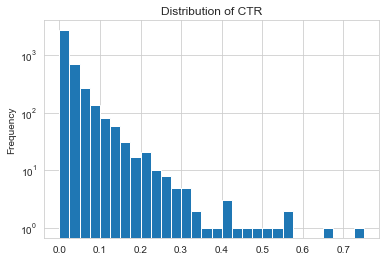

In [30]:
df_articles_coarse["CTR"].plot.hist(bins=30, title="Distribution of CTR", range=[0, 0.75], logy=True)

With the top 10 CTR ranking:

In [31]:
df_articles_coarse.sort_values(by=['CTR'], ascending=False).head(10)

,impressions,clicks,CTR
linkTarget,,,
list_of_european_countries,4,3,0.750000
exploration_of_mars,23,15,0.652174
wta_tour_championships,9,5,0.555556
the_lion_king,501,277,0.552894
gray_reef_shark,26,14,0.538462
ffestiniog_railway,2,1,0.500000
shenzhou_spacecraft,23,11,0.478261
battle_of_bicocca,13,6,0.461538
irish_theatre,14,6,0.428571


This last ranking might not be very useful since some articles have very low impressions, meaning we don't have enough data. The obtained CTR seems artificially very high.

In [32]:
print("The average number of clicks is " + str(df_articles_coarse.clicks.mean()))
print("The average number of impressions is " + str(df_articles_coarse.impressions.mean()))
print("The average CTR is " + str(df_articles_coarse.CTR.mean()))

The average number of clicks is 89.59489946051987
The average number of impressions is 5740.4065718489455
The average CTR is 0.030189658307541403


### 2.4: Visualizing the link positions
Let's visualize the link positions and clicks to show the regions with high click frequency. We adopt heatmaps to highlight these regions.

In [33]:
df_heatmap = df_links[['xpos', 'ypos', 'clicks', 'impressions', 'CTR']]

In [34]:
df_heatmap.sample(50)

,xpos,ypos,clicks,impressions,CTR
20933,1488,395,11,38,0.289474
111115,92,2307,3,87,0.034483
97904,692,282,1,137,0.007299
50952,1537,75,3,76,0.039474
7721,229,75,9,56,0.160714
54922,345,154,3,18,0.166667
69508,1014,154,0,8,0.000000
82536,550,5637,0,62,0.000000
70889,256,954,0,44,0.000000
49405,189,2463,1,250,0.004000


Now, let's see where in a page are located the links with highest clicks.

C:\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Clicks Heatmap')

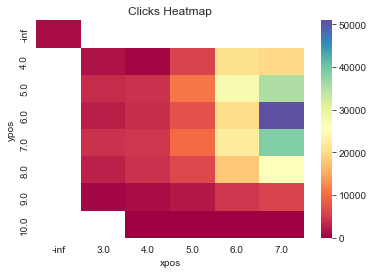

In [35]:
ax = plt.axes()
df_heatmap_clicks = pd.crosstab(np.around(np.log(df_heatmap['ypos'])), np.around(np.log(df_heatmap['xpos'])),
                                values=df_heatmap['clicks'], aggfunc=sum)
sns.heatmap(df_heatmap_clicks, cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('Clicks Heatmap')

We can compare that to the places where the links appear in average on a page:

C:\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Impressions Heatmap')

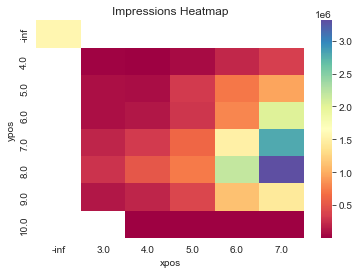

In [36]:
ax = plt.axes()
df_heatmap_impressions = pd.crosstab(np.around(np.log(df_heatmap['ypos'])), np.around(np.log(df_heatmap['xpos'])),
                                     values=df_heatmap['impressions'], aggfunc=sum)
sns.heatmap(df_heatmap_impressions, cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('Impressions Heatmap')

And finally, let's try to understand where the links with highest CTR are located:

Text(0.5, 1.0, 'CTR Heatmap')

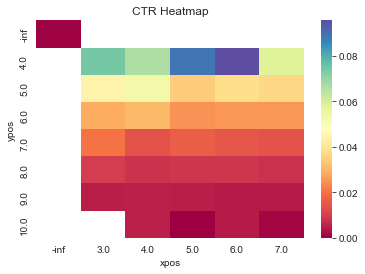

In [37]:
ax = plt.axes()
df_heatmap_CTR = df_heatmap_clicks / df_heatmap_impressions
sns.heatmap(df_heatmap_CTR, cmap=sns.color_palette("Spectral", as_cmap=True))
ax.set_title('CTR Heatmap')

These heatmaps are only the first iteration and will be made more clear for the next milestone.

Let's now investigate the relationship between two variables

In [38]:
df_links = df_links.fillna(0)
print(stats.pearsonr(df_links['xpos'], df_links['CTR']))

PearsonRResult(statistic=0.025033423109650857, pvalue=2.850711163911312e-17)


There is a very small (0.02), but significant (p < 0.05) positive correlation

In [39]:
print(stats.pearsonr(df_links['ypos'], df_links['CTR']))

PearsonRResult(statistic=-0.2094043231761328, pvalue=0.0)


There is a small (-0.2), but significant (p < 0.05) negative correlation. The pearson correlation coefficient for y position is 10 times higher than the one for x position.

Finally, we plot ypos/CTR and fit a regression model 

Text(0.5, 1.0, 'Linear Regression of CTR on ypos')

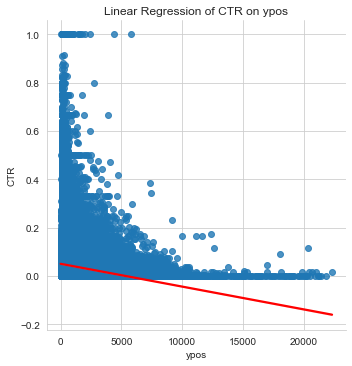

In [40]:
sns.lmplot(x="ypos", y="CTR", data=df_links, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')

We plan to continue the investigations with additionnal features, and plot more intuitive visualizations.

---
# Part 3: Observational Study
In this third section, we will be conducting an observational study to answer the following research question:
> Does the position of a link on a page affect its click-through rate?

# 3.1: Treatment & Control Group
Let's first define the treated and control groups. Treated group are the links that happened to be at the top of an article and that the user can see without scrolling (ypos < 900). Control group are the links that happened to be at the bottom of an article (ypos >= 900) and that the user needs to scroll to see.

In [41]:
df_treatment = df_links.loc[df_links['is_on_top'] == 1]
df_control = df_links.loc[df_links['is_on_top'] == 0]

Now, we are interested in comparing the outcome variable, the CTR, in both groups as a first analysis.

In [42]:
print(df_treatment.CTR.describe())  # statistical description of the CTR in the treated group
print(df_control.CTR.describe())  # statistical description of the CTR in the control group

count    57395.000000
mean         0.055285
std          0.098601
min          0.000000
25%          0.000000
50%          0.015152
75%          0.071356
max          1.000000
Name: CTR, dtype: float64
count    56579.000000
mean         0.017655
std          0.043457
min          0.000000
25%          0.000000
50%          0.000000
75%          0.016949
max          1.000000
Name: CTR, dtype: float64


What about the CTR density distribution in both groups?

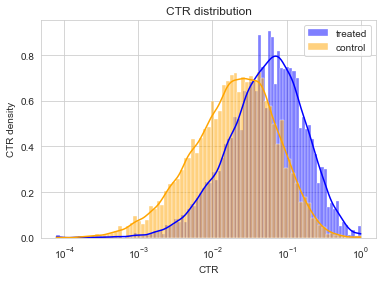

In [43]:
# remove null values because log_scale is set to true for better visualization
df_treatment = df_treatment.loc[df_treatment["CTR"] != 0]
df_control = df_control.loc[df_control["CTR"] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True, color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True, color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution', xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

The treated group has:
- higher mean CTR value
- higher percentile (50%, 75%)
- 75% of the CTR values lie below 0.071
- 50% of the CTR values lie below 0.015

The control group has:

- lower mean CTR value
- lower percentile (50%, 75%)
- 75% of the CTR values lie below 0.016
- 50% of the CTR values lie below 0.0 (or equal to 0 as CTR > 0)

We conclude that, in general, the treated group have higher CTR values than the control one.

### 3.2: Let's take a closer look at the data

As the data was gathered on individual behaviors in the scope of the Wikispeedia game, observational studies become a pillar in a causal analysis.

First, we could think of the **source article length** as a confounder acting on the link position.

Second, the semantic similarity between a link and the article in which it exists could affect its position. For example, we can expect that links that are most related to the article are at the top since they gather the most important information. Thus, the **semantic similarity** could act as a confounder since not all links have the same probabilities to be at the top of an article.

In this section, we discover the distribution of these confounders in both the treated and control group to assess our hypotheses through different visualizations.

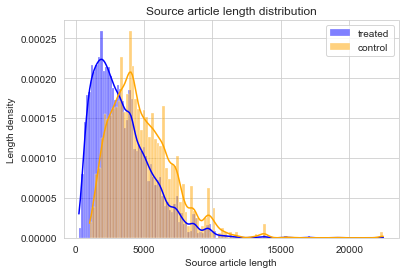

In [44]:
# Confounder 1: source article length

ax = sns.histplot(df_treatment['length'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(df_control['length'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Source article length distribution', xlabel='Source article length', ylabel='Length density')
plt.legend()
plt.show()

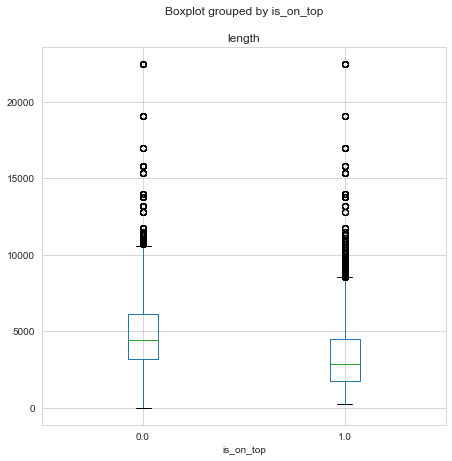

In [45]:
# Confounder 1: source article length

df_links.boxplot(by='is_on_top', column='length', figsize=[7, 7], grid=True)
plt.show()

From the graphs above, one can see that links that are at the top tend to exist in shorter articles. This might give an intuition of how much the source article length affect its target links position.

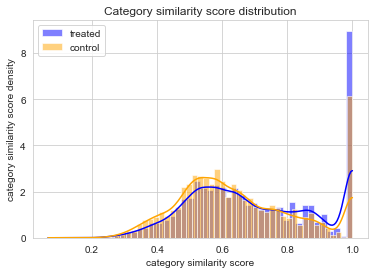

In [46]:
# Confounder 2: semantic similarity score between links and articles in which they exists

ax = sns.histplot(df_treatment['category_similarity_score'], kde=True, stat='density', color='blue', label='treated')
ax = sns.histplot(df_control['category_similarity_score'], kde=True, stat='density', color='orange', label='control')
ax.set(title='Category similarity score distribution', xlabel='category similarity score',
       ylabel='category similarity score density')
plt.legend()
plt.show()

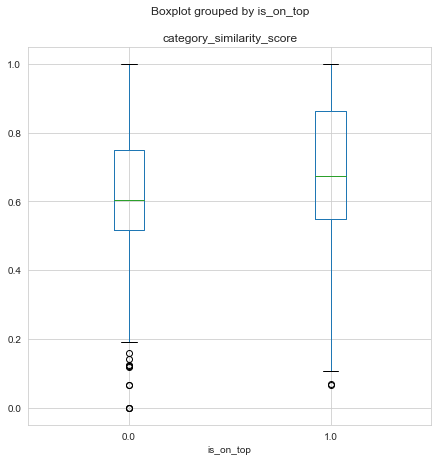

In [47]:
# Confounder 2: semantic similarity score between links and articles in which they exists

df_links.boxplot(by='is_on_top', column='category_similarity_score', figsize=[7, 7], grid=True)
plt.show()

As we can observe from the two plots above, links existing at the top tend to be more semantically related to their corresponding source article.

### 3.3: A propensity score model
A way to handle covariates is by matching links into pairs (treated, control) with respect to their propensity score. The propensity score can be measured through a logistic regression and for each data point, it represents its probability to be at the top of an article given the proposed covariates, features.

In [48]:
# standardize the continuous covariates
df_links['length'] = (df_links['length'] - df_links['length'].mean()) / df_links['length'].std()
df_links['category_similarity_score'] = (df_links['category_similarity_score'] - df_links[
    'category_similarity_score'].mean()) / df_links['category_similarity_score'].std()

# logistic regression
mod = smf.logit(formula='is_on_top ~ length + category_similarity_score ', data=df_links)

res = mod.fit()

# Extract the propensity scores
df_links['Propensity_score'] = pd.Series(res.predict())

print(res.summary())

Optimization terminated successfully.
         Current function value: 0.622879
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              is_on_top   No. Observations:               113974
Model:                          Logit   Df Residuals:                   113971
Method:                           MLE   Df Model:                            2
Date:                Fri, 23 Dec 2022   Pseudo R-squ.:                  0.1013
Time:                        17:38:12   Log-Likelihood:                -70992.
converged:                       True   LL-Null:                       -78998.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -0.0098      0.006     -1.531      0.126      -0.

From the logistic regression summary obtained above, the p-values (=0.000) confirm the effect of the source article length and the similarity score on the link position since they are less than 0.05, resulting in a significant effect.

### 3.4: Matching
As the probability for two data points to have the same propensity score (real values) is negligeable, approximate matching is performed. For this, we use a K-nearest neighbors model to get the k closest neighbors to each link with respect to their propensity score. Then, each treated link is matched with a control link if this latter is considered as one of its neighbors. They share the same range of propensity scores within a chosen radius.

In [49]:
# update dataframes
df_treatment = df_links.loc[df_links['is_on_top'] == 1]
df_control = df_links.loc[df_links['is_on_top'] == 0]

# remove NaN values (sanity check):
df_links.dropna(inplace=True)

# Here, we define the K-NN hyperparameters: radius and number of neighbors.
## These latter have been carefully chosen after several tests.

# we choose the K-nn model to vote among neighbors within 25% of standard deviation of the propensity score radius.
radius_neighbors = np.std(df_links['Propensity_score']) * 0.25

# we choose 10 as the number of neighbors to be used in the model.
num_neighbors = 10

# K-NN
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=num_neighbors, radius=radius_neighbors)

# extract the Propensity_score column
Propensity_score = df_links[['Propensity_score']]

# fit the K-NN model to the extracted column
knn.fit(Propensity_score)

NearestNeighbors(n_neighbors=10, radius=0.045341210374161334)

In [50]:
# run the K-NN model to extract for each datapoint, its neighbors ids.
_, neighbor_ids = knn.kneighbors(Propensity_score)
df_links.reset_index(inplace=True)

matching = []  # store the matched data points from the control group

for id_row, row in df_links.iterrows():

    # uf the row is in the control group
    if row['is_on_top'] == 0:
        df_links.loc[id_row, 'matched'] = np.nan  # because we want to match
        # each treated link with a control one and not the opposite.
    # else if the row is in the treated group
    else:
        # for each link in the treated group, loop over its k neighbors
        for neighbor_id in neighbor_ids[id_row, :]:

            # check if the neighbor is in the control group and the treated link is not matching with itself
            if (id_row != neighbor_id) and (df_links.loc[neighbor_id, 'is_on_top'] == 0):

                # check if the control link have a match already
                if neighbor_id not in matching:
                    df_links.loc[id_row, 'matched'] = neighbor_id  # match the treated link to a controlled link
                    matching.append(neighbor_id)  # add the matched id from the control group
                    break

In [51]:
# dataframe containing only matched rows from the treated group
df_treatment_matched = df_links.dropna(subset=['matched'])  # because links from the control group have NaN values

# indexes of the matched links from the control group to each of the links in the treated group
matched_control_ids = df_treatment_matched['matched'].astype(int)

# dataframe containing only matched rows from the control group
df_control_matched = df_links.loc[matched_control_ids, :]

# concatenate the matched treatment and control groups into a single dataframe
df_matched = pd.concat([df_treatment_matched, df_control_matched])

# drop NaN CTR values
df_matched.dropna(subset=['CTR'], inplace=True)

Now that our data is matched, let's compare again the CTR statistical description and distribution between the treated and control links and see if there is a change.

In [52]:
# matched control and treatment
df_matched_treatment = df_matched.loc[df_matched['is_on_top'] == 1]  #links positioned at the top
df_matched_control = df_matched.loc[df_matched['is_on_top'] == 0]  #links positioned at the bottom

print(df_matched_treatment.CTR.describe())  # statistical description of the CTR in the treated group
print(df_matched_control.CTR.describe())  # statistical description of the CTR in the control group

count    29871.000000
mean         0.055014
std          0.094457
min          0.000000
25%          0.000000
50%          0.019608
75%          0.070423
max          1.000000
Name: CTR, dtype: float64
count    29871.000000
mean         0.020978
std          0.047941
min          0.000000
25%          0.000000
50%          0.000000
75%          0.022698
max          1.000000
Name: CTR, dtype: float64


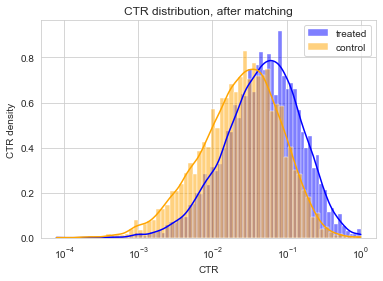

In [53]:
# remove null values because log_scale is set to true for better visualization
df_treatment = df_matched_treatment.loc[df_matched_treatment["CTR"] != 0]
df_control = df_matched_control.loc[df_matched_control["CTR"] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True, color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True, color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution, after matching', xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

PearsonRResult(statistic=-0.20753706890359347, pvalue=0.0)


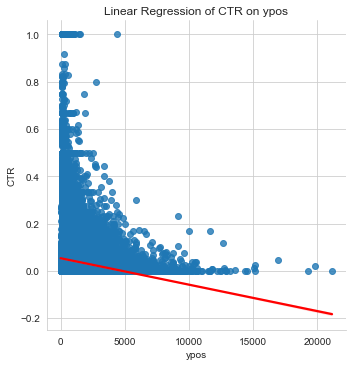

In [54]:
sns.lmplot(x="ypos", y="CTR", data=df_matched, line_kws={'color': 'red'})  #linear regression
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')
print(stats.pearsonr(df_matched['ypos'], df_matched['CTR']))

Again, the p-value shows a significant effect of the position on the CTR (< 0.05). This, indeed, confirms that **the higher a link is positioned, the higher its CTR will be.**

Let's push further the analysis by matching only links that have the same article source!

In [55]:
matching = []  # store the matched data points from the control group

for id_row, row in df_links.iterrows():

    # If the row is in the control group
    if row['is_on_top'] == 0:
        df_links.loc[id_row, 'matched'] = np.nan  # because we want to match
        # each treated link with a control one and not the opposite.
    # else if the row is in the treated group
    else:
        # for each link in the treated group, loop over its k neighbors
        for neighbor_id in neighbor_ids[id_row, :]:

            # check if the neighbor is in the control group and the treated link is not matching with itself
            # and the link source of the treated link is the same as the control link
            if (id_row != neighbor_id) and (df_links.loc[neighbor_id, 'is_on_top'] == 0) and (
                    row['linkSource'] == df_links.loc[neighbor_id, 'linkSource']):

                # check if the control link have a match already
                if neighbor_id not in matching:
                    df_links.loc[id_row, 'matched'] = neighbor_id  # match the treated link to a controlled link
                    matching.append(neighbor_id)  # add the matched id from the control group
                    break

In [56]:
# dataframe containing only matched rows from the treated group
df_treatment_matched = df_links.dropna(subset=['matched'])  # because links from the control group have NaN values

# indexes of the matched links from the control group to each of the links in the treated group
matched_control_ids = df_treatment_matched['matched'].astype(int)

# dataframe containing only matched rows from the control group
df_control_matched = df_links.loc[matched_control_ids, :]

# concatenate the matched treatment and control groups into a single dataframe
df_matched = pd.concat([df_treatment_matched, df_control_matched])

# drop NaN CTR values
df_matched.dropna(subset=['CTR'], inplace=True)

In [57]:
# matched control and treatment
df_matched_treatment = df_matched.loc[df_matched['is_on_top'] == 1]  #links positioned at the top
df_matched_control = df_matched.loc[df_matched['is_on_top'] == 0]  #links positioned at the bottom

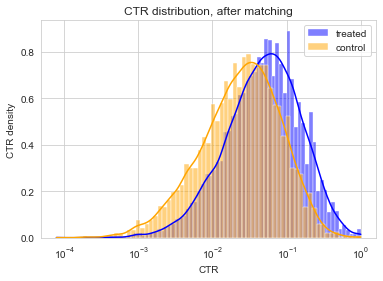

In [58]:
# Remove null values because log_scale is set to true for better visualization
df_treatment = df_matched_treatment.loc[df_matched_treatment['CTR'] != 0]
df_control = df_matched_control.loc[df_matched_control['CTR'] != 0]

ax = sns.histplot(df_treatment['CTR'], stat='density', kde=True, color='blue', label='treated', log_scale=True)
ax = sns.histplot(df_control['CTR'], stat='density', kde=True, color='orange', label='control', log_scale=True)
ax.set(title='CTR distribution, after matching', xlabel='CTR', ylabel='CTR density')
plt.legend()
plt.show()

PearsonRResult(statistic=-0.2083954338892232, pvalue=0.0)


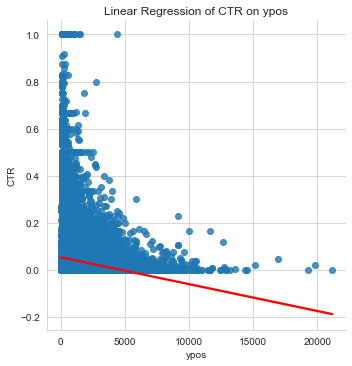

In [59]:
sns.lmplot(x="ypos", y="CTR", data=df_matched, line_kws={'color': 'red'})
ax = plt.gca()
ax.set_title('Linear Regression of CTR on ypos')
print(stats.pearsonr(df_matched['ypos'], df_matched['CTR']))

After link matching while sharing the same source article, a negative correlation is found between the CTR and the link position. Again, one can conclude that as the link position increases in the article, its CTR decreases.

---
### Appendices - Interactive Graph Generation for Website
In the following sections, the code used to generate interactive graphs for the website will be presented. These graphs are generated using the `plotly` library and are exported as HTML files.

### Appendix 1 - Density Map for Clicks

In [61]:
x = np.array(df_links.xpos)
y = np.array(df_links.ypos)
y_modified = max(y) - np.array(df_links.ypos)

z = np.array(df_links.clicks)

colorscale = ['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98, 0.98, 0.98)]

hovertext = ['Clicks: {}'.format(z[i]) for i in range(len(z))]

fig = px.density_contour(x=x, y=y_modified, z=z)
fig.update_traces(contours_coloring="fill", contours_showlabels=True)
fig.update_layout(yaxis_range=[28000, 30000])

#x axis
fig.update_xaxes(visible=False)

#y axis
fig.update_yaxes(visible=False)

fig.write_html("output/figures/density_map.html", auto_open=True)

### Appendix 2 - Heatmap for Clicks

In [62]:
# compute new graph for plotly visualization
## the objective is to draw connexe components of G, removing some outliers
G = nx.from_pandas_edgelist(df_links, source='linkSource', target='linkTarget', edge_attr='clicks',
                            create_using=nx.DiGraph)
Gcc = sorted(nx.strongly_connected_components(G), key=len, reverse=True)
G = G.subgraph(Gcc[0])

# Compute the node positions for the graph
pos = nx.fruchterman_reingold_layout(G)

# Extract the edge weights from the Graph object
edge_weights = [G[u][v]['clicks'] for u, v in G.edges()]

# Create a scattergl trace for the nodes
node_trace = go.Scattergl(
    x=[pos[node][0] for node in G.nodes],
    y=[pos[node][1] for node in G.nodes],
    text=[node for node in G.nodes],
    mode='markers',
    hoverinfo='text',
    marker=dict(symbol='circle-dot', size=5, color='#6959CD')
)

# Create a scattergl trace for the edges
edge_trace = go.Scattergl(
    x=[pos[u][0] for u, v in G.edges()],
    y=[pos[u][1] for u, v in G.edges()],
    text=[G[u][v]['clicks'] for u, v in G.edges()],
    mode='lines',
    hoverinfo='text',
    line=dict(color='rgb(50,50,50)', width=0.05)
)

# Create a Figure object
fig = go.Figure(data=[node_trace, edge_trace])

# Set the layout of the Figure object
fig.update_layout(
    title='Wikispeedia Network',
    hovermode='closest',
    hoverlabel=dict(
        bgcolor='#FFFFFF',
        font_size=16
    ),
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showticklabels=False
    ),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

# Save the plot as an HTML file and show it in a browser
pio.write_html(fig, file='output/figures/graph_Wikispeedia.html', auto_open=True)

### Appendix 4 - Ranking of pages

In [64]:
# Ranking pages

df_articles = pd.read_csv("output/3_output_link_position.csv")

# Sort df_articles by the 'clicks' column in descending order
df_articles_sorted = df_articles.sort_values("clicks", ascending=False)

# Keep the top 5 rows
df_top_5 = df_articles_sorted.nlargest(5, "clicks")

# Use the melt function to pivot the data
df = df_top_5.melt(id_vars=["linkTarget"], value_vars=["impressions", "clicks"], var_name="Metrics",
                   value_name="metrics_value")

fig = px.bar(df, x="metrics_value", y="linkTarget", color="Metrics", orientation="h",
             color_discrete_sequence=['#1d3299', '#259fcc'])

# Reverse the order of the bars
fig.update_layout(yaxis=dict(autorange="reversed"), paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)')

# Increase the font size of the y axis values
fig.layout.yaxis.tickfont.size = 20

# Add a title to the figure
fig.update_layout(title="Articles with highest impressions")

fig.layout.title.x = 0.5
fig.layout.titlefont.size = 30

#x axis
fig.update_xaxes(visible=False)

# Hide the y axis title
fig.layout.yaxis.title = ""

fig.write_html("output/figures/ranking.html", auto_open=True)

### Appendix 5 - CTR as function of ypos

In [65]:
# plot CTR vs ypos

fig = px.scatter(df_links, x="ypos", y="CTR", color="CTR",
                 custom_data=["linkSource", "linkTarget", "impressions", "clicks"])

fig.update_traces(
    hovertemplate="<br>".join([
        "y position: %{x}",
        "CTR: %{y}",
        "Link Source: %{customdata[0]}",
        "Link Target: %{customdata[1]}",
        "Impressions: %{customdata[2]}",
        "Clicks: %{customdata[3]}"
    ])
)

fig.write_html("output/figures/CTR_ypos_plot.html", auto_open=True)

### Appendix 6 - CTR as function of ypos with linear regression

In [66]:
# the same but with the linear regression

fig = px.scatter(df_matched, x="ypos", y="CTR", color="CTR", custom_data=["linkSource", "linkTarget", "impressions", "clicks"], trendline="ols")

model = px.get_trendline_results(fig)
alpha = model.iloc[0]["px_fit_results"].params[0]
beta = model.iloc[0]["px_fit_results"].params[1]

fig = px.scatter(df_links, x="ypos", y="CTR", trendline="ols")

rsq = model.iloc[0]["px_fit_results"].rsquared
fig.add_trace(go.Scatter(x=[100], y=[100],
                         name = "R-squared" + ' = ' + str(round(rsq, 2)),
                         showlegend=True,
                         mode='markers',
                         marker=dict(color='rgba(0,0,0,0)')
                         ))

fig.data[0].name = 'Observations'
fig.data[0].showlegend = True
fig.data[1].name = fig.data[1].name  + ' y = ' + str(round(alpha, 2)) + ' + ' + str(round(beta, 3)) + 'x'
fig.data[1].showlegend = True

fig.data[1].update(line_color='red')

fig.update_layout(title=dict(text="OLS regression with the matched dataset",
                             font=dict(size=18),
                             x=0.5,
                             xanchor='center'),
                  yaxis_range=[-0.2, 1.2],
                  paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)')

fig.write_html("output/figures/CTR_ypos_plot_match.html", auto_open=True)